In [17]:
import pandas as pd
import cv2
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import time
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# from PIL import Image

import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import LFWPairs
from torchvision import transforms
import time
import torch.optim.lr_scheduler as lr_scheduler




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

## Full neural network pipleline.


1. Creating the Dataset Object.
2. Creating the DataLoaders.
3. Decideing on hyper-parameters (number of layers, learning rate, etc.).
4. Creating the Model Class.
5. Creating the model, optimizer and loss function objects.
6. Training the model with a pytorch training loop.
7. Testing the model.

###Creating the Dataset Object

In [19]:
train_set = LFWPairs(root="",split = "train", download=True, transform=transforms.Compose([transforms.Resize((105,105)),transforms.Grayscale(),ToTensor()]))
test_set = LFWPairs(root="",split = "test", download=True, transform=transforms.Compose([transforms.Resize((105,105)),transforms.Grayscale(),ToTensor()]))
train, val = train_test_split(train_set, test_size=0.1, random_state=42)

Files already downloaded and verified
Files already downloaded and verified


###Creating the DataLoaders###

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=32,
                                          shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                          batch_size=32,
                                          shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val,
                                          batch_size=32,
                                          shuffle=True)

###Decideing on hyper-parameters###

In [21]:
EPOCHS = 100
LR = 0.0001

###Creating the Model Class###

In [22]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [23]:
from imageio.core.util import OrderedDict
class Siamese_Model(nn.Module):
    def __init__(self):
        super(Siamese_Model, self).__init__()  
        self.part1=nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=10),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(kernel_size=2), 
              torch.nn.Dropout(0.7, False),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(kernel_size=2), 
              torch.nn.Dropout(0.7, False),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(kernel_size=2),
              torch.nn.Dropout(0.7, False),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.Dropout(0.7, False),
              
              Flatten(),
              nn.Linear(1152, 32),
            ).apply(init_weights)

        self.part2=nn.Sequential(nn.Linear(32, 1),nn.Sigmoid())

    def forward(self, one, two):
        one = self.part1(one)
        two = self.part1(two)
        final=self.part2(torch.abs(one - two))
        return final

@torch.no_grad()
def init_weights(m):
  if isinstance(m, nn.Conv2d):
    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01)
    if m.bias is not None:
          torch.nn.init.trunc_normal_(m.bias, mean=0.5, std=0.01)
  elif isinstance(m, nn.Linear):
    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01)
    if m.bias is not None:
        torch.nn.init.trunc_normal_(m.bias, mean=0.0, std=0.01)





###Creating the model, optimizer and loss function objects###

In [54]:
#שלב 5
model = Siamese_Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optimizer = torch.optim.SGD(model.parameters(), lr=LR)

#Binary Cross Entropy:
criterion = torch.nn.BCELoss()

#decreasing the learning rate factor by 1% after each epoch:
lmbda = lambda epoch: 0.99
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [25]:
model.parameters

<bound method Module.parameters of Siamese_Model(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.7, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.7, inplace=False)
    (10): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.7, inplace=False)
    (15): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))


###Training the model with a pytorch training loop###

In [26]:
def train_step(model, dataloader, optimizer, loss_fn, epoch):
    model.train()
    running_loss = 0.0
    for step, (img1,img2,label) in enumerate(dataloader):
        img1,img2, label = img1.to(device),img2.to(device), label.to(device)
        # getting the output of the model;
        pred = model(img1,img2)
        # getting the cost of the model
        loss = loss_fn(pred.float(), label.unsqueeze(1).float())
        # Backpropagation and updating the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

            

In [27]:
def threashold_sigmoid(t):
    """prob > 0.5 --> 1 else 0"""
    threashold = t.clone()
    threashold.data.fill_(0.5)
    return (t > threashold).float()

In [28]:
def test(model, dataloader, loss_fn, i=0):
    avg_accuracy, avg_loss = 0, 0

    for img1,img2, label  in dataloader:
        img1,img2, label = img1.to(device),img2.to(device), label.to(device)
        pred = model(img1,img2)
        loss = loss_fn(pred.float(), label.unsqueeze(1).float())
        avg_loss += loss.item()
        pred = torch.flatten(pred)
        output_labels = threashold_sigmoid(pred)
        avg_accuracy += (output_labels == label).sum()
    return {'loss': avg_loss / len(dataloader), 'accuracy': avg_accuracy / len(dataloader.dataset )}

In [29]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
epochs = []

x = time.time()
for epoch in range(EPOCHS):
    #train of each epoch:  
    epoch_loss = train_step(model, train_dataloader, optimizer, criterion, epoch)
    #save the results of each epoch
    epochs.append(epoch)
    metrics_train = test(model, train_dataloader, criterion)
    train_loss.append(metrics_train["loss"])
    train_acc.append(float(metrics_train["accuracy"]))
    metrics = test(model, test_dataloader, criterion)
    val_loss.append(metrics["loss"])
    val_acc.append(float(metrics["accuracy"]))
    print(f'Epoch: {epoch} Validation Loss: {metrics["loss"]} Validation Accuracy: {metrics["accuracy"]} Train_loss {metrics_train["loss"]}') 

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    if len(train_loss)>=5:
        if abs(val_loss[-1]-val_loss[-5])<0.0001 or val_loss[-1]-val_loss[-5]>0.05 :
            print("Early stopping")
            break   
y = time.time()
print("Total time (sec): "+str(y-x))


Epoch: 0 Validation Loss: 0.7077736407518387 Validation Accuracy: 0.49400001764297485 Train_loss 0.71100556159365
Epoch: 1 Validation Loss: 0.7189710326492786 Validation Accuracy: 0.49000000953674316 Train_loss 0.7008951280428015
Epoch: 2 Validation Loss: 0.7017511557787657 Validation Accuracy: 0.5139999985694885 Train_loss 0.7050791728323784
Epoch: 3 Validation Loss: 0.6974879167973995 Validation Accuracy: 0.5090000033378601 Train_loss 0.7042052115219227
Epoch: 4 Validation Loss: 0.7115591559559107 Validation Accuracy: 0.4820000231266022 Train_loss 0.700378612331722
Epoch: 5 Validation Loss: 0.6997899617999792 Validation Accuracy: 0.5240000486373901 Train_loss 0.7059534511704376
Epoch: 6 Validation Loss: 0.7069234699010849 Validation Accuracy: 0.5070000290870667 Train_loss 0.6970622263092926
Epoch: 7 Validation Loss: 0.6952763628214598 Validation Accuracy: 0.5190000534057617 Train_loss 0.6962914415027784
Epoch: 8 Validation Loss: 0.7021518386900425 Validation Accuracy: 0.5279999971389

###Testing the model###

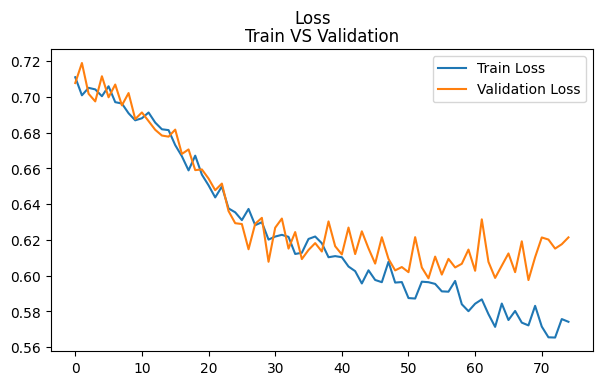

In [35]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(7,4), dpi=100)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs,val_loss, label="Validation Loss")
plt.legend(loc='Train loss', fontsize=10)
plt.title("Train VS Validation")
plt.suptitle("Loss")
plt.show()

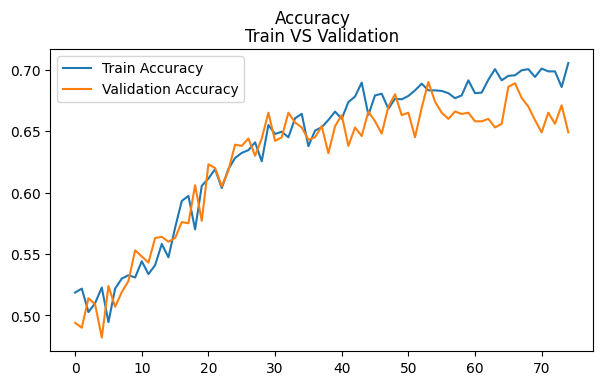

In [36]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(7,4), dpi=100)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs,val_acc, label="Validation Accuracy")
plt.legend(loc='Train Accuracy', fontsize=10)
plt.title("Train VS Validation")
plt.suptitle("Accuracy")
plt.show()

In [45]:
metrics = test(model, test_dataloader, criterion)
print(f'Test Loss: {metrics["loss"]} Test Accuracy: {metrics["accuracy"]}')

Test Loss: 0.6087785533496312 Test Accuracy: 0.6818181872367859


##Examples of accurate and misclassifications

In [51]:
torch.manual_seed(2)
test_dataloader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

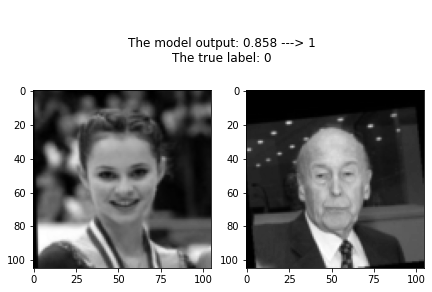

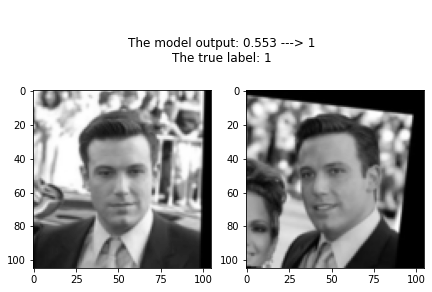

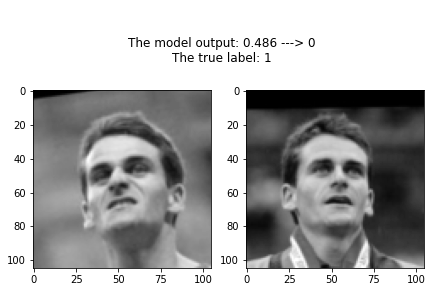

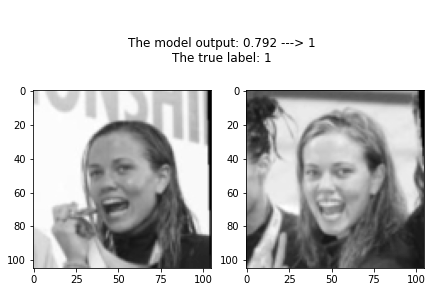

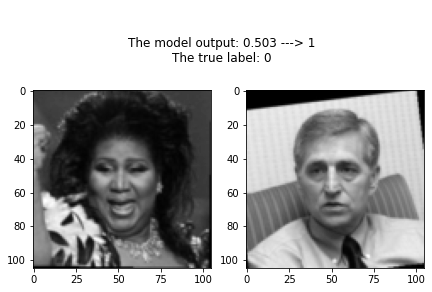

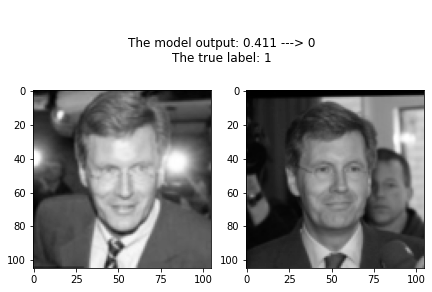

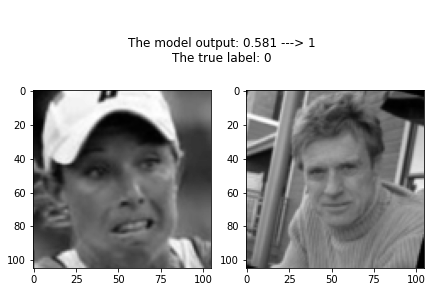

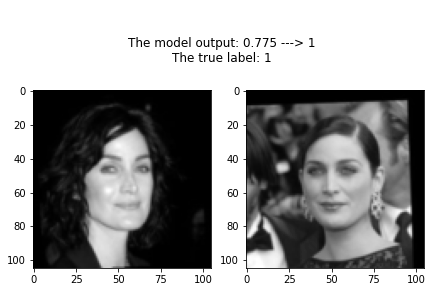

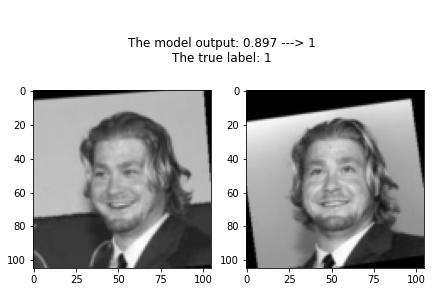

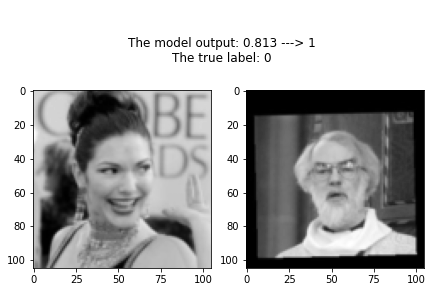

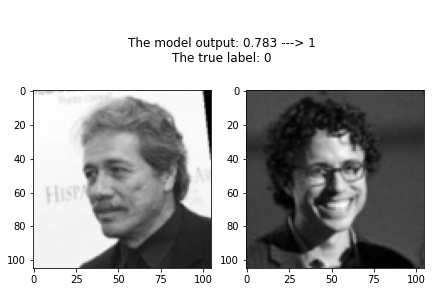

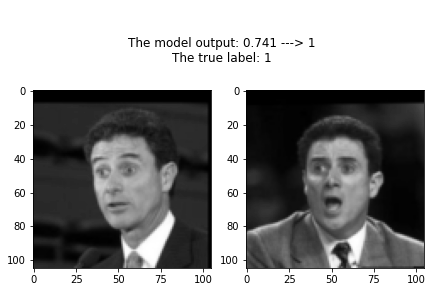

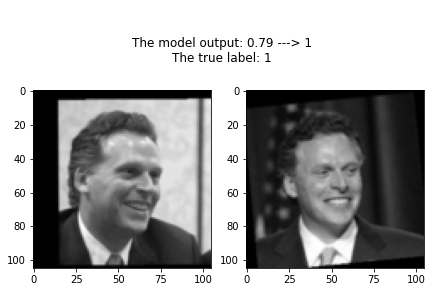

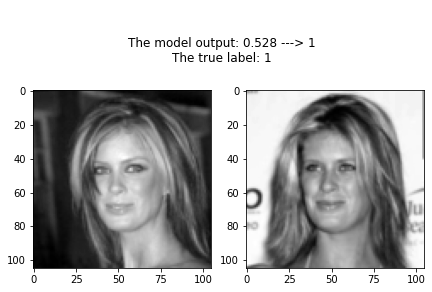

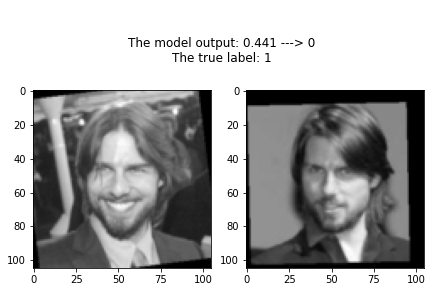

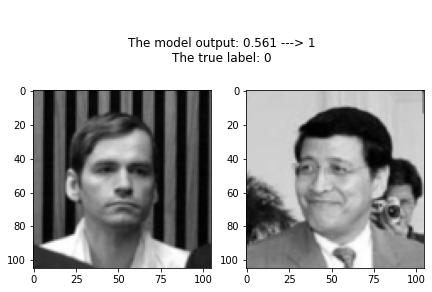

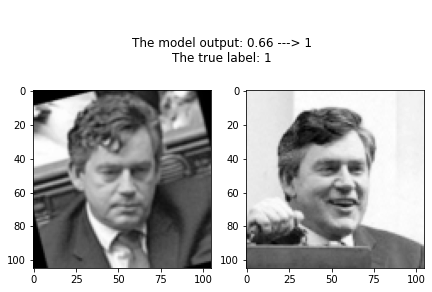

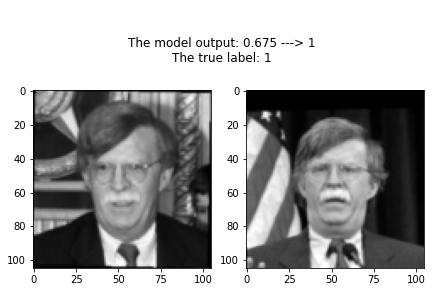

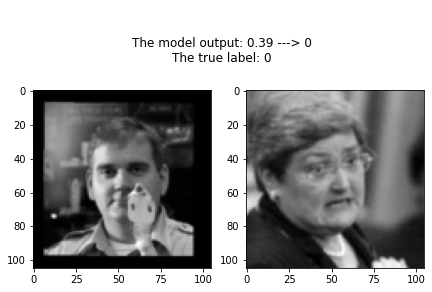

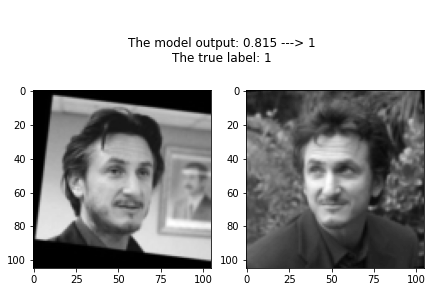

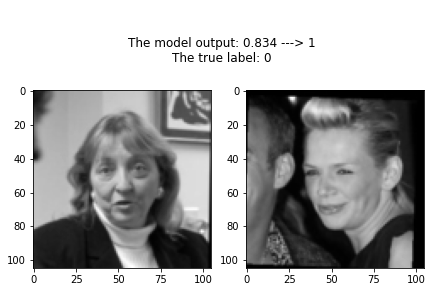

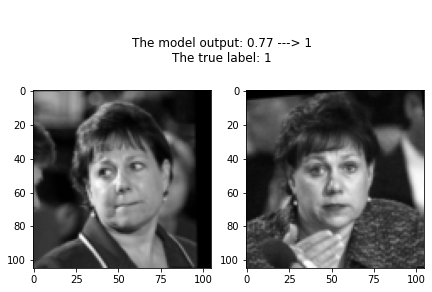

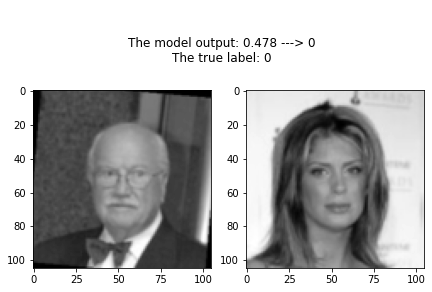

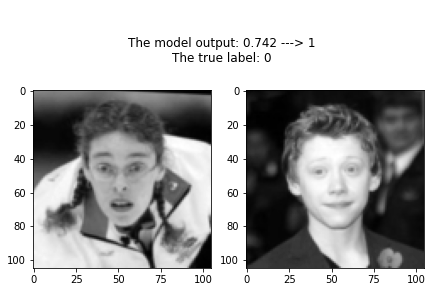

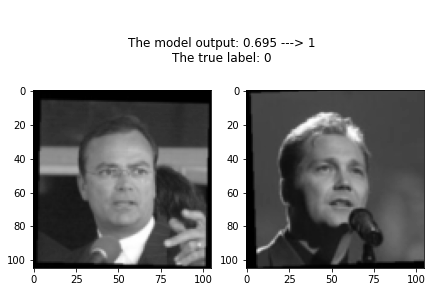

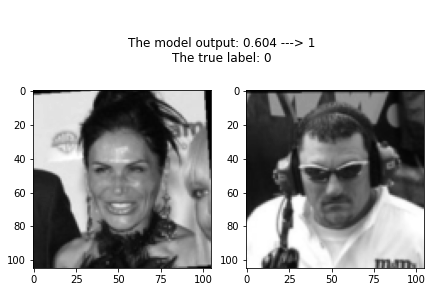

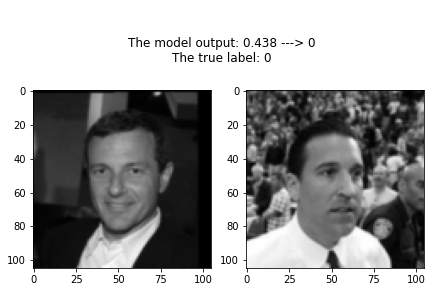

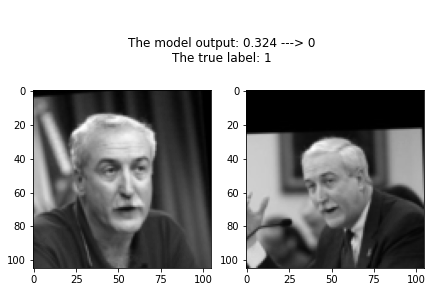

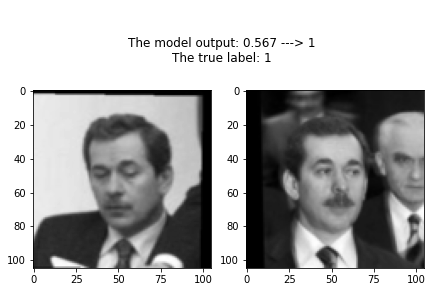

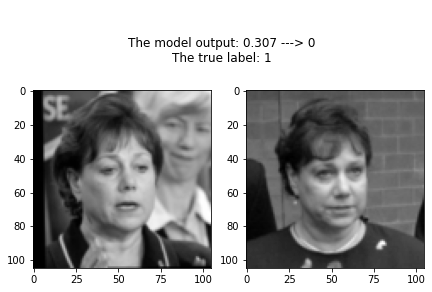

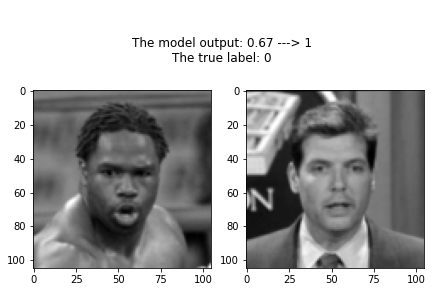

In [53]:
torch.manual_seed(2)
for i, (img1,img2, label)  in enumerate(test_dataloader):
    img1,img2, label = img1.to(device),img2.to(device), label.to(device)
    im1 = img1[0].cpu()
    im2 = img2[0].cpu()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 5)
    ax1.imshow(im1.numpy()[0],  cmap='gray')
    ax2.imshow(im2.numpy()[0], cmap='gray')
    pred = model(img1,img2)
    p = round(float(pred[0]),3)
    if p >0.5:
      c=1
    else:
      c=0
    fig.suptitle("\n"+"\n" +"The model output: "+ str(p)+ " ---> "+str(c) + "\n"+
                 "The true label: "+str(int(label)))
    if i==30:
      break